# **Efficiency of the supply chain**

The efficiency of a supply chain can be measured by the efficiency of supplier performance and the order fulfilment process. Hence, to improve the efficiency of the supply chain, we will analyse these 2 factors to come up with a two-pronged approach to make the supply chain more efficient.

In [113]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import statsmodels.api as sm
import numpy as np
from itertools import product
import os
from dotenv import load_dotenv
import psycopg2
import sqlalchemy
import warnings
warnings.filterwarnings('ignore')
from langdetect import detect, DetectorFactory
from textblob import TextBlob
from scipy import stats
import matplotlib.pyplot as plt

In [114]:
# Load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

In [115]:
# Create a database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [116]:
def create_status_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            s.product_id,
            s.shipping_id, 
            s.fulfilment,
            s.ship_service_level,
            s.estimated_delivery_date,
            s.fulfilled_by,
            h.status,
            h.update_date
        FROM
            shipping_status AS s
        
        RIGHT JOIN
            shipping_history AS h
            ON s.shipping_id = h.shipping_id
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection


def create_products_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            product_id,
            category,
            origin_area
        FROM
            products
        
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection


## Analysing supplier performace to identify bottlenecks

We can infer the performance of the product based on whether a purchased product is frequently cancelled or returned to the seller. 
Some reasons a product would be cancelled are:
- The buyer found a cheaper alternative
- The buyer realised that they are not satisfied with the product (price, reviews etc.)

Some reasons a product would be returned to the seller are:
- The product that came was damaged
- The product was not up to the standard of the buyer

All these reasons can be attributed to the performance of the product and hence the supplier.

After getting the list of products that have a lacklustre performance among buyers, we can check the areas where these suppliers come from to identify any potential bottlenecks.

In [119]:
# Create shipping_status_df

shipping_status_df = create_status_df()

# Ensure date columns are in correct column type
shipping_status_df['estimated_delivery_date'] = pd.to_datetime(shipping_status_df['estimated_delivery_date'])
shipping_status_df['update_date'] = pd.to_datetime(shipping_status_df['update_date'])

shipping_status_df.head()

,product_id,shipping_id,fulfilment,ship_service_level,estimated_delivery_date,fulfilled_by,status,update_date
0,B09DL9978Y,10001,Amazon,Expedited,2019-01-03,None,Pending,2019-01-01
1,B09DL9978Y,10001,Amazon,Expedited,2019-01-03,None,Packed,2019-01-02
2,B09DL9978Y,10001,Amazon,Expedited,2019-01-03,None,At logistics facility,2019-01-02
3,B09DL9978Y,10001,Amazon,Expedited,2019-01-03,None,Shipping,2019-01-04
4,B09DL9978Y,10001,Amazon,Expedited,2019-01-03,None,Delivered to buyer,2019-01-05


In [95]:
# Create products table

products_df = create_products_df()

products_df.head()

,product_id,category,origin_area
0,B07JW9H4J1,Computers&Accessories|Accessories&Peripherals|...,"Dongguan, China"
1,B098NS6PVG,Computers&Accessories|Accessories&Peripherals|...,"Ningbo, China"
2,B096MSW6CT,Computers&Accessories|Accessories&Peripherals|...,"Shanghai, China"
3,B08HDJ86NZ,Computers&Accessories|Accessories&Peripherals|...,"Dongguan, China"
4,B08CF3B7N1,Computers&Accessories|Accessories&Peripherals|...,"Ningbo, China"


In [96]:
# Filter for items that are returned or cancelled

returned_df = shipping_status_df[shipping_status_df['status'].isin(['Returned', 'Cancelled'])]

returned_df.head()

,product_id,shipping_id,fulfilment,ship_service_level,estimated_delivery_date,fulfilled_by,status,update_date
6,B09DL9978Y,10002,Amazon,Standard,NaT,None,Cancelled,2019-01-04
87,B00C3GBCIS,10018,Amazon,Expedited,2019-01-05,None,Returned,2019-01-11
89,B08ZN4B121,10019,Amazon,Expedited,NaT,None,Cancelled,2019-01-03
121,B09DL9978Y,10026,Amazon,Expedited,NaT,None,Cancelled,2019-01-03
138,B07GXHC691,10030,Amazon,Expedited,NaT,None,Cancelled,2019-01-04


In [97]:
# Create count for product_ids in returned_df

product_counts_df = returned_df['product_id'].value_counts().reset_index()
product_counts_df = product_counts_df.sort_values(by='count', ascending=False)

product_counts_df.head()

,product_id,count
0,B07XLML2YS,1080
1,B0B9XLX8VR,652
2,B09DL9978Y,580
3,B09Y5FZK9N,293
4,B07VX71FZP,293


In [98]:
product_counts_df = pd.merge(product_counts_df, products_df, how='left', on='product_id')

product_counts_df.nlargest(10, 'count')

,product_id,count,category,origin_area
0,B07XLML2YS,1080,Electronics|Cameras&Photography|SecurityCamera...,"Higashiomi-shi, Japan"
1,B0B9XLX8VR,652,"Electronics|HomeTheater,TV&Video|Televisions|S...","Shanghai, China"
2,B09DL9978Y,580,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...","Huizhou, China"
3,B09Y5FZK9N,293,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"Shenzhen, China"
4,B07VX71FZP,293,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...","Ningbo, China"
5,B07Z1X6VFC,284,Computers&Accessories|Accessories&Peripherals|...,"Ningbo, China"
6,B00KRCBA6E,277,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...","Higashiomi-shi, Japan"
7,B00Y4ORQ46,264,"Electronics|Headphones,Earbuds&Accessories|Hea...","Ningbo, China"
8,B07GXHC691,255,Electronics|Mobiles&Accessories|MobileAccessor...,"Guangzhou, China"
9,B08NCKT9FG,246,Computers&Accessories|Accessories&Peripherals|...,"Shenzhen, China"


After filtering for the products that are cancelled or returned, we tabulate the number of times the product was cancelled or returned, and extract the origin areas of the top 10 products that were cancelled or returned. We can see that the products generally come from Higashiomi-shi in Japan or several areas in China including Shenzhen and Ningbo. Therefore, we can infer that the suppliers producing products in the respective categories are poorer performing suppliers and would need to improve the quality of their products through conducting more customer surveys and research and development.

Next, we want to infer the performance of a supplier based on how long they take to ship out their products after an order is placed.

In [99]:
# Filter for 'Pending' and 'Packed' statuses
filtered_df = shipping_status_df[shipping_status_df['status'].isin(['Pending', 'Packed'])]

# Pivot the DataFrame to have 'Pending' and 'Packed' as columns
pending_packed_df = filtered_df.pivot_table(index=['product_id', 'shipping_id'], 
                                            columns='status', 
                                            values='update_date', 
                                            aggfunc='first').reset_index()

# Ensure that pending -> cancelled rows are not included in the df
pending_packed_df.dropna(how='any', inplace=True)

# Calculate the number of days from 'Pending' to 'Packed'
pending_packed_df['days_to_pack'] = (pending_packed_df['Packed'] - pending_packed_df['Pending']).dt.days

# Group by 'product_id' and calculate mean and mode for 'days_to_pack'
mean_df = pending_packed_df.groupby('product_id').agg(
    mean_days_to_pack=('days_to_pack', 'mean'),
    mode_days_to_pack=('days_to_pack', lambda x: stats.mode(x, keepdims=True)[0][0])
).reset_index()

# Display the resulting DataFrame
mean_df.head()

,product_id,mean_days_to_pack,mode_days_to_pack
0,B0085W2MUQ,1.434783,0
1,B008FWZGSG,1.880000,1
2,B00C3GBCIS,1.645455,1
3,B00J5DYCCA,1.551020,1
4,B00KIDSU8S,1.522727,0


In [125]:
# Top 10 observations by mean_days_to_pack
top_10_mean = mean_df.nlargest(10, 'mean_days_to_pack')

top_10_mean.style.format({'': '{:.2f}'}).set_properties(
    **{'text-align': 'center'}).set_caption("Average Days to Pack an Order")


,product_id,mean_days_to_pack,mode_days_to_pack
103,B09V175NP7,2.461538,3
34,B07GVGTSLN,2.400000,5
124,B0BDRVFDKP,2.250000,1
26,B0752LL57V,2.153846,1
129,B0BF57RN3K,2.070175,1
126,B0BF54972T,1.963636,0
89,B09LMMFW3S,1.923077,1
36,B07JF9B592,1.913043,1
116,B0B84KSH3X,1.888889,0
73,B08WLY8V9S,1.881579,1


In [129]:
# Check the areas the problematic products are from

products_lst = list(top_10_mean[top_10_mean['mean_days_to_pack'] > 2]['product_id'])

products_df[products_df['product_id'].isin(products_lst)]


,product_id,category,origin_area
89,B07GVGTSLN,Computers&Accessories|Accessories&Peripherals|...,"Foshan, China"
296,B0BDRVFDKP,Electronics|Accessories|MemoryCards|MicroSD,"Carmona, Philippines"
346,B0BF57RN3K,Electronics|WearableTechnology|SmartWatches,"Zhongshan, China"
489,B09V175NP7,Electronics|WearableTechnology|SmartWatches,"Kunshan, China"
676,B0752LL57V,OfficeProducts|OfficeElectronics|Calculators|B...,"Guangzhou, China"


We can see that the products that took a longer time to be packed are from China and Philippines. We can infer that some suppliers in these areas need to improve on the amount of time required to pack their orders so that their products can be delivered quickly and safely to the buyers.

## Optimise order fulfillment processes to reduce delivery times

Order fulfillment processes are done by either Amazon or 3rd-party logistics companies. We can reduce delivery times by improving the pain-points in the order fulfilment process. These can be done by:
- Checking the frequency of lost packages
- Checking the frequency of late deliveries


In [103]:
# Check the frequency of lost packages

lost_df = shipping_status_df[shipping_status_df['status'] == 'Lost']

lost_df

,product_id,shipping_id,fulfilment,ship_service_level,estimated_delivery_date,fulfilled_by,status,update_date
56294,B08G28Z33M,22260,Amazon,Standard,2019-04-12,None,Lost,2019-04-11
119878,B07XLML2YS,36110,Merchant,Standard,2019-07-16,Shiprocket Fulfillment,Lost,2019-07-21


We see that there are few incidences of lost packages and hence lost packages are not a main cause of concern in the order fulfilment process.

Now, we will analyse the frequency of late deliveries.

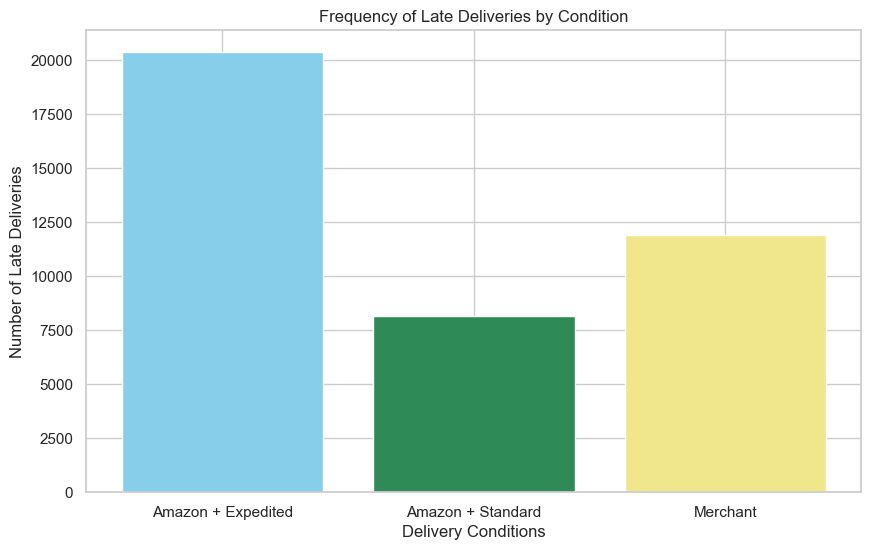

In [104]:
# Step 1: Filter the data to only rows where status is 'Delivered to buyer'
delivered_df = shipping_status_df[shipping_status_df['status'] == 'Delivered to buyer']

# Step 2: Identify late deliveries
# Convert date columns to datetime if not already in datetime format
delivered_df['update_date'] = pd.to_datetime(delivered_df['update_date'])
delivered_df['estimated_delivery_date'] = pd.to_datetime(delivered_df['estimated_delivery_date'])

# Create a boolean column 'is_late' to check lateness
delivered_df['is_late'] = delivered_df['update_date'] > delivered_df['estimated_delivery_date']

# Step 3: Filter and count unique late shipping_ids for each condition
conditions = {
    "Amazon + Expedited": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Expedited'),
    "Amazon + Standard": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Standard'),
    "Merchant": (delivered_df['fulfilment'] == 'Merchant')
}

# Step 4: Create a dictionary to store the count of late deliveries for each condition
late_counts = {condition: delivered_df[condition_filter & delivered_df['is_late']]['shipping_id'].nunique()
               for condition, condition_filter in conditions.items()}

# Step 5: Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(late_counts.keys(), late_counts.values(), color=['skyblue', 'seagreen', 'khaki'])
plt.xlabel('Delivery Conditions')
plt.ylabel('Number of Late Deliveries')
plt.title('Frequency of Late Deliveries by Condition')
plt.show()


Although we see that there are many late deliveries for expedited fulfilled-by-Amazon orders, it may be because there are more expedited-fulfilled-by-Amazon orders in this dataset. Hence, we check the proportion of late deliveries for each delivery condition instead for a more fair comparison.

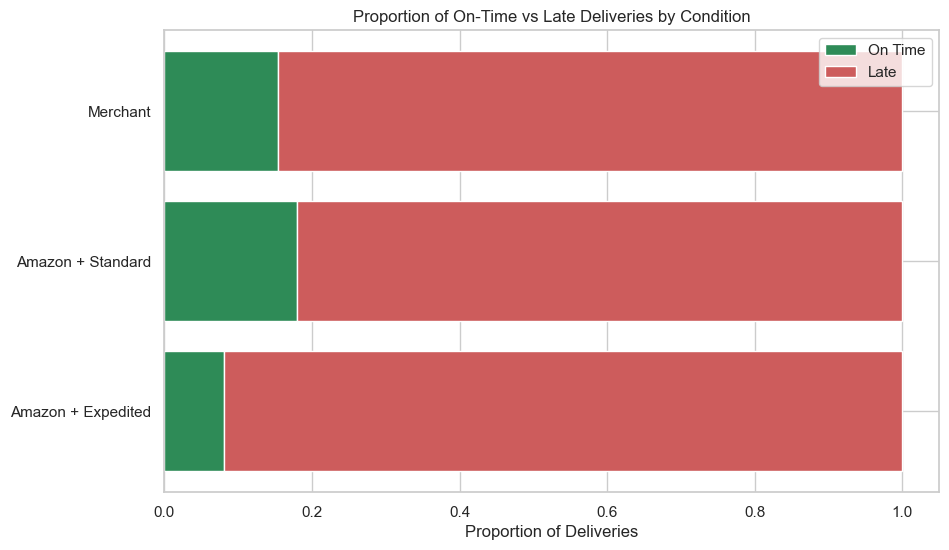

In [105]:
# Check the proportion of late deliveries by delivery condition

conditions = {
    "Amazon + Expedited": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Expedited'),
    "Amazon + Standard": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Standard'),
    "Merchant": (delivered_df['fulfilment'] == 'Merchant')
}

# Calculate the proportion of late vs on-time deliveries for each condition
proportions = []

for condition_name, condition_filter in conditions.items():
    condition_data = delivered_df[condition_filter]
    total_deliveries = condition_data['shipping_id'].nunique()  # total unique shipping IDs
    late_deliveries = condition_data[condition_data['is_late']]['shipping_id'].nunique()  # unique late shipping IDs
    on_time_deliveries = total_deliveries - late_deliveries
    
    # Append the proportion data for each condition
    proportions.append({
        'Condition': condition_name,
        'Late': late_deliveries / total_deliveries,
        'On Time': on_time_deliveries / total_deliveries
    })

proportions_df = pd.DataFrame(proportions)

# Plot horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each condition as a stacked bar
for i, row in proportions_df.iterrows():
    ax.barh(row['Condition'], row['On Time'], color='seagreen', label='On Time' if i == 0 else "")
    ax.barh(row['Condition'], row['Late'], left=row['On Time'], color='indianred', label='Late' if i == 0 else "")

# Labels and title
ax.set_xlabel('Proportion of Deliveries')
ax.set_title('Proportion of On-Time vs Late Deliveries by Condition')
ax.legend(loc='upper right')

plt.show()

We observe that across all conditions, there are more late deliveries than on-time deliveries. However, expedited fulfilled-by-Amazon orders have a higher proportion of late deliveries, followed by fulfilled-by-Merchant orders and then standard fulfilled-by-Amazon orders.

It seems that the order fulfilment processes across all fulfilment parties are not performing well, and hence we want to find out:
- How late the deliveries are according to the delivery condition
- Which step in the order fulfilment process is taking a longer time than expected

In [106]:
# Check how late the deliveries are

# Calculate lateness in days for late deliveries
delivered_df['days_late'] = (delivered_df['update_date'] - delivered_df['estimated_delivery_date']).dt.days

# Step 3: Define conditions
conditions = {
    "Amazon + Expedited": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Expedited'),
    "Amazon + Standard": (delivered_df['fulfilment'] == 'Amazon') & (delivered_df['ship_service_level'] == 'Standard'),
    "Merchant": (delivered_df['fulfilment'] == 'Merchant')
}
  
# Step 4: Calculate average lateness for each condition
average_lateness = []

for condition_name, condition_filter in conditions.items():
    condition_data = delivered_df[condition_filter & delivered_df['is_late']]
    avg_days_late = condition_data['days_late'].mean()
    average_lateness.append({
        'Condition': condition_name,
        'Average Days Late': avg_days_late if pd.notnull(avg_days_late) else 0  # Set to 0 if no late deliveries
    })

# Convert to DataFrame for a clean table format
lateness_report = pd.DataFrame(average_lateness)

lateness_report.style.format({'Average Days Late': '{:.2f}'}).set_properties(
    **{'text-align': 'center'}).set_caption("Average Days Late for Each Delivery Condition")


,Condition,Average Days Late
0,Amazon + Expedited,3.29
1,Amazon + Standard,3.81
2,Merchant,4.16


Although there is a larger proportion of late deliveries for expedited fulfilled-by-Amazon orders, fulfilled-by-merchant orders are **later on average**. 

Now, we want to check which step in the order fulfilment process took the longest for orders fulfilled by the three different conditions.

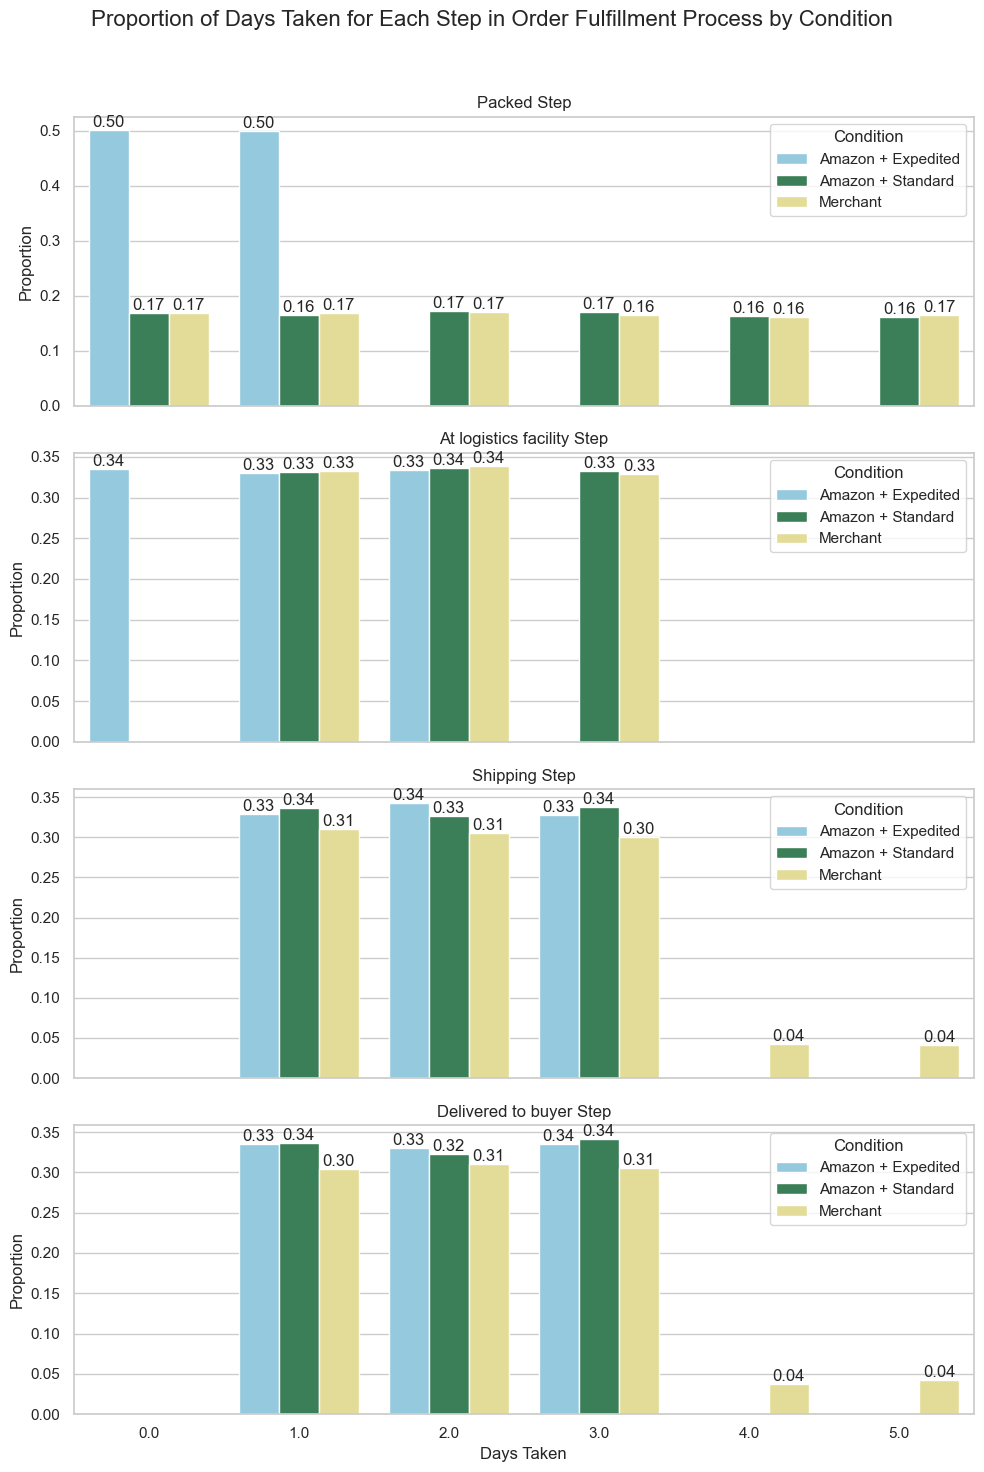

In [107]:
# Check which step took the longest

# Filter out only successful orders that get delivered
# Define conditions for successful orders
successful_orders = shipping_status_df.groupby('shipping_id').filter(lambda x: 
    list(x['status']) == ["Pending", "Packed", "At logistics facility", "Shipping", "Delivered to buyer"]
)

# Calculate days between each step for each shipping_id
successful_orders['update_date'] = pd.to_datetime(successful_orders['update_date'])
successful_orders = successful_orders.sort_values(['shipping_id', 'update_date'])

successful_orders['days_from_previous'] = successful_orders.groupby('shipping_id')['update_date'].diff().dt.days

# Drop NaNs
successful_orders = successful_orders.dropna(subset=['days_from_previous'])


# Add a new 'Condition' column based on fulfilment and ship_service_level
def label_condition(row):
    if row['fulfilment'] == 'Amazon' and row['ship_service_level'] == 'Expedited':
        return 'Amazon + Expedited'
    elif row['fulfilment'] == 'Amazon' and row['ship_service_level'] == 'Standard':
        return 'Amazon + Standard'
    elif row['fulfilment'] == 'Merchant':
        return 'Merchant'
    return None

successful_orders['Condition'] = successful_orders.apply(label_condition, axis=1)

fulfillment_steps = ["Packed", "At logistics facility", "Shipping", "Delivered to buyer"]


# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Create a dictionary to map each condition to a color
condition_colors = {"Amazon + Expedited": "skyblue", "Amazon + Standard": "seagreen", "Merchant": "khaki"}

# Calculate the count and proportion of days taken for each step within each condition
proportion_data = successful_orders.groupby(['Condition', 'status', 'days_from_previous']).size().reset_index(name='count')
proportion_data['proportion'] = proportion_data.groupby(['Condition', 'status'])['count'].transform(lambda x: x / x.sum())


# Initialize a figure with multiple subplots, one for each fulfillment step
fig, axes = plt.subplots(nrows=len(fulfillment_steps), ncols=1, figsize=(10, 15), sharex=True)
fig.suptitle("Proportion of Days Taken for Each Step in Order Fulfillment Process by Condition", fontsize=16)

# Plot each fulfillment step in a separate subplot
for i, step in enumerate(fulfillment_steps):
    step_data = proportion_data[proportion_data['status'] == step]
    step_data = step_data[step_data['proportion'] > 0]
    
    # Plot data for each condition, with days_from_previous as x-axis and proportion as y-axis
    sns.barplot(
        data=step_data,
        x='days_from_previous',
        y='proportion',
        hue='Condition',
        palette=condition_colors,
        ax=axes[i]
    )

    for p in axes[i].patches:
        height = p.get_height()
        if height > 0:  # Only add labels where the height is greater than zero
            axes[i].text(
                p.get_x() + p.get_width() / 2, 
                height, 
                f'{height:.2f}', 
                ha='center', 
                va='bottom'
            )
    
    # Set titles and labels
    axes[i].set_title(f"{step} Step")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xlabel("Days Taken")
    axes[i].legend(title="Condition")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title and subplots
plt.show()

We see that in general, the number of days taken to deliver orders varies more within a condition than between conditions. This suggests that instead of one step in a fulfilment process causing delays, the overall order fulfilment process may just be taking longer days than expected, especially for expedited fulfilled-by-Amazon and standard fulfilled-by-Amazon orders. Amazon's fulfilment process should work on reducing the variance in the number of days taken for each step by perhaps improving the overall system since there is no specific pain-point that can be identified from this dataset.

However, we see that for orders fulfilled by Merchant, there are a few orders that take a longer than usual amount of time to complete the Shipping and Delivered to buyer steps.

In [108]:
# Check what fulfilment company is causing the larger variance in days taken to complete fulfilment

print(successful_orders[(successful_orders['status'].isin(['Shipping', 'Delivered to buyer'])) & (successful_orders['days_from_previous'] > 3)]['fulfilled_by'].unique())

['Quickshift Fulfillment']


We see that the fulfilment company Quickshift Fulfillment is taking longer than other companies to complete the Shipping and Delivered to buyer steps. Hence, Quickshift Fulfillment should work on improving the quality of their dispatching service from their logistics facility. This can be done by increasing the manpower dispatched for the final delivery step or improving the efficiency of the routes taken during the final delivery step so that the amount of time taken to delivery each order can be decreased and more orders can be delivered in a shorter time.

## **Conclusion**

To optimise the performance of Amazon supply chain, we have analysed both supplier performance and order fulfilment processes to identify issues that can be improved on.

We suggest a 2-pronged approach targeting suppliers and order fulfilment parties:
- Suppliers should:
    - Improve the quality of their products if their products are frequently returned or orders are frequently cancelled.
    - Reduce the time needed to pack their products after an order is placed

- Order fulfilment parties should:
    - Improve on their overall order fulfilment process since there are more late deliveries than on-time deliveries or adjust the estimated delivery date
    - Reduce the variance in the number of days needed for each step in the order fulfilment process
    - The company, Quickshift Fulfillment, is performing poorly in the final steps of the order fulfilment process and should optimise the quality of the final dispatching service to the buyer.